<a href="https://colab.research.google.com/github/artemkush1/ML_predict_CS-GO_matches/blob/master/prepare_data_and_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

from keras import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, PReLU
from keras.optimizers import Adam
from keras.losses import MAPE
from keras.losses import MAE

PATH = '/content/drive/My Drive/Colab Notebooks/cs-go_matches/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Load data

In [0]:
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cs-go_matches/df_6months.csv', comment='#', delimiter=',').drop(columns=['Unnamed: 0'])
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cs-go_matches/data_stat_all_maps.csv').drop(columns=['Unnamed: 0'])# .set_index('url')
#df = df.loc[df['total_maps'] < 2
df

,match_url,url_team1,url_team2,event_url,players_url_1,players_url_2,total_maps,maps_played,maps_url,maps_name,score1_maps,score2_maps,picks,date,score1,score2,h2h_wins1,h2h_wins2,rank1,rank2,last_maps1_score_team1,last_maps1_opponent_score_team1,last_maps2_score_team1,last_maps2_opponent_score_team1,last_maps3_score_team1,last_maps3_opponent_score_team1,last_maps4_score_team1,last_maps4_opponent_score_team1,last_maps5_score_team1,last_maps5_opponent_score_team1,last_maps6_score_team1,last_maps6_opponent_score_team1,last_maps7_score_team1,last_maps7_opponent_score_team1,last_maps8_score_team1,last_maps8_opponent_score_team1,last_maps9_score_team1,last_maps9_opponent_score_team1,last_maps10_score_team1,last_maps10_opponent_score_team1,...,map_played6Vertigo_opponent_team1,map_played7Vertigo_team1,map_played7Vertigo_opponent_team1,map_played8Vertigo_team1,map_played8Vertigo_opponent_team1,map_played9Vertigo_team1,map_played9Vertigo_opponent_team1,map_played10Vertigo_team1,map_played10Vertigo_opponent_team1,Times playedVertigo_team2,Total rounds playedVertigo_team2,Rounds wonVertigo_team2,Win percentVertigo_team2,Pistol roundsVertigo_team2,Pistol rounds wonVertigo_team2,Pistol round win percentVertigo_team2,CT round win percentVertigo_team2,T round win percentVertigo_team2,Round win percent after getting first killVertigo_team2,Round win percent after receiving first deathVertigo_team2,map_played1Vertigo_team2,map_played1Vertigo_opponent_team2,map_played2Vertigo_team2,map_played2Vertigo_opponent_team2,map_played3Vertigo_team2,map_played3Vertigo_opponent_team2,map_played4Vertigo_team2,map_played4Vertigo_opponent_team2,map_played5Vertigo_team2,map_played5Vertigo_opponent_team2,map_played6Vertigo_team2,map_played6Vertigo_opponent_team2,map_played7Vertigo_team2,map_played7Vertigo_opponent_team2,map_played8Vertigo_team2,map_played8Vertigo_opponent_team2,map_played9Vertigo_team2,map_played9Vertigo_opponent_team2,map_played10Vertigo_team2,map_played10Vertigo_opponent_team2
0,/matches/2341924/hard-legion-vs-hellraisers-lo...,/team/10421/hard-legion,/team/5310/hellraisers,/events/5359/lootbet-season-7,"['/player/12027/Krad', '/player/13982/Forester...","['/player/11250/Flarich', '/player/8786/jR', '...",3,3,['/stats/matches/mapstatsid/103958/hard-legion...,"['Inferno', 'Dust2', 'Train']","['16', '9', '16']","['14', '16', '12']","[-1, 1]",2020-06-11,2,1,4,2,World rank: #30,World rank: #66,16,7,16,10,16,6,9,16,16,12,6,16,16,19,16,5,10,16,16,12,...,19,5,16,17,19,0,0,0,0,6,181,90,0.500,12,8,0.667,0.477,0.516,0.687,0.337,16,13,11,16,19,17,15,19,13,16,16,10,0,0,0,0,0,0,0,0
1,/matches/2341888/bantz-vs-truckers-with-attitu...,/team/10712/bantz,/team/10713/truckers-with-attitude,/events/5319/lpl-pro-league-season-5,"['/player/18737/Falcon', '/player/20017/motion...","['/player/18736/pz', '/player/11806/JD', '/pla...",3,3,['/stats/matches/mapstatsid/103959/bantz-vs-tr...,"['Vertigo', 'Inferno', 'Mirage']","['19', '7', '9']","['16', '16', '16']","[-1, 1]",2020-06-11,1,2,0,1,World rank: #108,World rank: #100,16,6,16,13,8,16,16,19,16,6,11,16,17,19,16,10,16,8,16,11,...,0,0,0,0,0,0,0,0,0,1,30,16,1.000,2,1,0.500,0.467,0.600,0.722,0.250,16,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/matches/2341576/natus-vincere-vs-mad-lions-dr...,/team/4608/natus-vincere,/team/8362/mad-lions,/events/5285/dreamhack-masters-spring-2020-europe,"['/player/7594/flamie', '/player/7998/s1mple',...","['/player/10330/acoR', '/player/14148/sjuush',...",3,2,['/stats/matches/mapstatsid/103961/natus-vince...,"['Mirage', 'Overpass']","['16', '16']","['5', '7']","[-1, 1]",2020-06-11,2,0,0,0,World rank: #1,World rank: #17,12,16,19,22,15,12,10,13,11,13,13,3,13,11,15,12,2,13,13,11,...,0,0,0,0,0,0,0,0,0,2,54,22,0.000,4,1,0.250,0.400,0.414,0.714,0.212,9,16,13,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/matches/2342056/pc419-vs-overt-esea-mdl-seaso...,/team/9750/pc419,/team/10711/overt,/events/5264/esea-mdl-season-34-australia,"['/player/11793/dash', '/player/11803/Fluent%2...","['/player/12584/vax'

In [0]:
unknown_rank = '500'

def preprocess_rank(rank_, df):
    for i in range(len(df[rank_])):
        df[rank_][i] = df[rank_][i].split('#')[-1]
        if df[rank_][i] == '\nUnranked\n':
            df[rank_][i] = unknown_rank
    return df


def preprocess_tour(df):
    tmp = pd.get_dummies(df['event_type'])
    df = pd.concat([df, tmp], axis=1).drop(columns=['event_type'])
    return df


def drop_columns_prefix(prefix_, df):
    df = df.drop(columns=list(df.filter(regex=prefix_, axis=1).columns))
    return df


df = preprocess_rank('rank1', df)
df = preprocess_rank('rank2', df)
df = preprocess_tour(df)
#df = drop_columns_prefix('5last_match', df)
df = drop_columns_prefix('map_played', df)
df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(4000, 570)

In [0]:
for i in range(1, 3):
    for k in range(11, 21):
        df = df.drop(columns=[f'last_maps{k}_score_team{i}', f'last_maps{k}_opponent_score_team{i}'])
df

,match_url,url_team1,url_team2,event_url,players_url_1,players_url_2,total_maps,maps_played,maps_url,maps_name,score1_maps,score2_maps,picks,date,score1,score2,h2h_wins1,h2h_wins2,rank1,rank2,last_maps1_score_team1,last_maps1_opponent_score_team1,last_maps2_score_team1,last_maps2_opponent_score_team1,last_maps3_score_team1,last_maps3_opponent_score_team1,last_maps4_score_team1,last_maps4_opponent_score_team1,last_maps5_score_team1,last_maps5_opponent_score_team1,last_maps6_score_team1,last_maps6_opponent_score_team1,last_maps7_score_team1,last_maps7_opponent_score_team1,last_maps8_score_team1,last_maps8_opponent_score_team1,last_maps9_score_team1,last_maps9_opponent_score_team1,last_maps10_score_team1,last_maps10_opponent_score_team1,...,Pistol round win percentTrain_team1,CT round win percentTrain_team1,T round win percentTrain_team1,Round win percent after getting first killTrain_team1,Round win percent after receiving first deathTrain_team1,Times playedTrain_team2,Total rounds playedTrain_team2,Rounds wonTrain_team2,Win percentTrain_team2,Pistol roundsTrain_team2,Pistol rounds wonTrain_team2,Pistol round win percentTrain_team2,CT round win percentTrain_team2,T round win percentTrain_team2,Round win percent after getting first killTrain_team2,Round win percent after receiving first deathTrain_team2,Times playedVertigo_team1,Total rounds playedVertigo_team1,Rounds wonVertigo_team1,Win percentVertigo_team1,Pistol roundsVertigo_team1,Pistol rounds wonVertigo_team1,Pistol round win percentVertigo_team1,CT round win percentVertigo_team1,T round win percentVertigo_team1,Round win percent after getting first killVertigo_team1,Round win percent after receiving first deathVertigo_team1,Times playedVertigo_team2,Total rounds playedVertigo_team2,Rounds wonVertigo_team2,Win percentVertigo_team2,Pistol roundsVertigo_team2,Pistol rounds wonVertigo_team2,Pistol round win percentVertigo_team2,CT round win percentVertigo_team2,T round win percentVertigo_team2,Round win percent after getting first killVertigo_team2,Round win percent after receiving first deathVertigo_team2,Lan,Online
0,/matches/2341924/hard-legion-vs-hellraisers-lo...,/team/10421/hard-legion,/team/5310/hellraisers,/events/5359/lootbet-season-7,"['/player/12027/Krad', '/player/13982/Forester...","['/player/11250/Flarich', '/player/8786/jR', '...",3,3,['/stats/matches/mapstatsid/103958/hard-legion...,"['Inferno', 'Dust2', 'Train']","['16', '9', '16']","['14', '16', '12']","[-1, 1]",2020-06-11,2,1,4,2,30,66,16,7,16,10,16,6,9,16,16,12,6,16,16,19,16,5,10,16,16,12,...,0.462,0.580,0.537,0.763,0.325,15,400,200,0.467,30,16,0.533,0.563,0.427,0.690,0.315,8,228,100,0.250,16,9,0.562,0.444,0.432,0.686,0.238,6,181,90,0.500,12,8,0.667,0.477,0.516,0.687,0.337,0,1
1,/matches/2341888/bantz-vs-truckers-with-attitu...,/team/10712/bantz,/team/10713/truckers-with-attitude,/events/5319/lpl-pro-league-season-5,"['/player/18737/Falcon', '/player/20017/motion...","['/player/18736/pz', '/player/11806/JD', '/pla...",3,3,['/stats/matches/mapstatsid/103959/bantz-vs-tr...,"['Vertigo', 'Inferno', 'Mirage']","['19', '7', '9']","['16', '16', '16']","[-1, 1]",2020-06-11,1,2,0,1,108,100,16,6,16,13,8,16,16,19,16,6,11,16,17,19,16,10,16,8,16,11,...,0.500,0.556,0.389,0.800,0.238,1,36,19,1.000,2,1,0.500,0.611,0.444,0.762,0.200,0,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,1,30,16,1.000,2,1,0.500,0.467,0.600,0.722,0.250,0,1
2,/matches/2341576/natus-vincere-vs-mad-lions-dr...,/team/4608/natus-vincere,/team/8362/mad-lions,/events/5285/dreamhack-masters-spring-2020-europe,"['/player/7594/flamie', '/player/7998/s1mple',...","['/player/10330/acoR', '/player/14148/sjuush',...",3,2,['/stats/matches/mapstatsid/103961/natus-vince...,"['Mirage', 'Overpass']","['16', '16']","['5', '7']","[-1, 1]",2020-06-11,2,0,0,0,1,17,12,16,19,22,15,12,10,13,11,13,13,3,13,11,15,12,2,13,13,11,...,0.643,0.619,0.386,0.781,0.235,10,257,136,0.500,20,12,0.600,0.574,0.474,0.819,0.291,1,15,2,0.000,2,0,0.000,0.000,0.167,0.000,0.200,2,54,22,0.000,4,1,0.

In [0]:
list(df.columns)

## Preprocessing

In [0]:
target1 = 'score1'
target2 = 'score2'

for i in df.columns:
    try:
        df[i].astype(float)
    except:
        df = df.drop(columns=[i])

arr = []
for x, y in zip(df[target1], df[target2]):
    if (x > y):
        arr.append(1)
    else:
        arr.append(0)
arr = np.array(arr)
print(len(arr))
df['target'] = arr
df


4000


,total_maps,maps_played,score1,score2,h2h_wins1,h2h_wins2,rank1,rank2,last_maps1_score_team1,last_maps1_opponent_score_team1,last_maps2_score_team1,last_maps2_opponent_score_team1,last_maps3_score_team1,last_maps3_opponent_score_team1,last_maps4_score_team1,last_maps4_opponent_score_team1,last_maps5_score_team1,last_maps5_opponent_score_team1,last_maps6_score_team1,last_maps6_opponent_score_team1,last_maps7_score_team1,last_maps7_opponent_score_team1,last_maps8_score_team1,last_maps8_opponent_score_team1,last_maps9_score_team1,last_maps9_opponent_score_team1,last_maps10_score_team1,last_maps10_opponent_score_team1,last_maps1_score_team2,last_maps1_opponent_score_team2,last_maps2_score_team2,last_maps2_opponent_score_team2,last_maps3_score_team2,last_maps3_opponent_score_team2,last_maps4_score_team2,last_maps4_opponent_score_team2,last_maps5_score_team2,last_maps5_opponent_score_team2,last_maps6_score_team2,last_maps6_opponent_score_team2,...,CT round win percentTrain_team1,T round win percentTrain_team1,Round win percent after getting first killTrain_team1,Round win percent after receiving first deathTrain_team1,Times playedTrain_team2,Total rounds playedTrain_team2,Rounds wonTrain_team2,Win percentTrain_team2,Pistol roundsTrain_team2,Pistol rounds wonTrain_team2,Pistol round win percentTrain_team2,CT round win percentTrain_team2,T round win percentTrain_team2,Round win percent after getting first killTrain_team2,Round win percent after receiving first deathTrain_team2,Times playedVertigo_team1,Total rounds playedVertigo_team1,Rounds wonVertigo_team1,Win percentVertigo_team1,Pistol roundsVertigo_team1,Pistol rounds wonVertigo_team1,Pistol round win percentVertigo_team1,CT round win percentVertigo_team1,T round win percentVertigo_team1,Round win percent after getting first killVertigo_team1,Round win percent after receiving first deathVertigo_team1,Times playedVertigo_team2,Total rounds playedVertigo_team2,Rounds wonVertigo_team2,Win percentVertigo_team2,Pistol roundsVertigo_team2,Pistol rounds wonVertigo_team2,Pistol round win percentVertigo_team2,CT round win percentVertigo_team2,T round win percentVertigo_team2,Round win percent after getting first killVertigo_team2,Round win percent after receiving first deathVertigo_team2,Lan,Online,target
0,3,3,2,1,4,2,30,66,16,7,16,10,16,6,9,16,16,12,6,16,16,19,16,5,10,16,16,12,16,11,13,16,16,13,22,18,16,9,9,16,...,0.580,0.537,0.763,0.325,15,400,200,0.467,30,16,0.533,0.563,0.427,0.690,0.315,8,228,100,0.250,16,9,0.562,0.444,0.432,0.686,0.238,6,181,90,0.500,12,8,0.667,0.477,0.516,0.687,0.337,0,1,1
1,3,3,1,2,0,1,108,100,16,6,16,13,8,16,16,19,16,6,11,16,17,19,16,10,16,8,16,11,16,6,16,14,16,8,16,12,16,7,13,16,...,0.556,0.389,0.800,0.238,1,36,19,1.000,2,1,0.500,0.611,0.444,0.762,0.200,0,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,1,30,16,1.000,2,1,0.500,0.467,0.600,0.722,0.250,0,1,0
2,3,2,2,0,0,0,1,17,12,16,19,22,15,12,10,13,11,13,13,3,13,11,15,12,2,13,13,11,16,10,5,16,16,7,16,12,16,12,18,22,...,0.619,0.386,0.781,0.235,10,257,136,0.500,20,12,0.600,0.574,0.474,0.819,0.291,1,15,2,0.000,2,0,0.000,0.000,0.167,0.000,0.200,2,54,22,0.000,4,1,0.250,0.400,0.414,0.714,0.212,0,1,1
3,1,1,10,16,0,0,162,138,9,16,9,16,2,16,2,16,6,16,13,16,16,14,4,16,6,16,16,8,6,16,18,22,6,16,8,16,16,6,16,9,...,0.333,0.067,0.200,0.000,5,115,45,0.200,10,5,0.500,0.458,0.343,0.667,0.194,0,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,1,30,14,0.000,2,1,0.500,0.400,0.533,0.812,0.071,0,1,0
4,1,1,16,14,1,0,68,130,16,5,16,11,13,16,10,16,16,13,16,13,16,8,13,16,10,16,16,6,17,19,16,5,14,16,9,16,6,16,7,16,...,0.569,0.551,0.739,0.340,2,64,33,0.500,4,1,0.250,0.545,0.484,0.676,0.333,6,144,93,0.833,12,9,0.750,0.652,0.640,0.816,0.386,3,92,46,0.667,6,2,0.333,0.556,0.447,0.681,0.311,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Split data on X and Y

In [0]:
#df1 = df.drop(columns=['score1', 'score2', 'pistol_round_1', 'pistol_round_15'])
df1 = df.drop(columns=['score1', 'score2', 'maps_played']) #, 'map_score1', 'map_score2', 'pick1', 'pick2'
X = df1.iloc[:, :-1].fillna(0)
Y = df1.iloc[:, -1]

# Choose best features

## Модель №1.
SelectKBest выбирает лучшие признаки.
chi2 является непрерывной случайной величиной хи-квадрат, которая определяется стандартным форматом и некоторыми параметрами формы для завершения своей спецификации. В частности, вычисляет статистику хи-квадрат между каждым неотрицательным признаком и классом.


---


Работает в большинстве случаев плохо



In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X.shape
X = SelectKBest(chi2, k=10).fit_transform(X, Y)
X.shape

(1254, 10)

## Модель №2.
Использование логистической регресии для определения наилучших признаков.


---

Отрабатывает лучше всего

In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
X.shape

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(4000, 160)

## Модель №3.
ExtraTreesClassifier - название говорит само за себя.

In [0]:
# Выбор лучших параметров
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, Y)
model = SelectFromModel(clf, prefit=True)
X = model.transform(X)

# Train_test split

In [0]:
X_test, X_train, y_test, y_train = train_test_split(np.array(X), np.array(Y), test_size=0.8, shuffle=False, random_state=0)
X_train.shape

(3200, 503)

# Train models

In [0]:
from google.colab import output
import lightgbm as lgb
try:
    from catboost import CatBoostClassifier
except:
    !pip install catboost
    from catboost import CatBoostClassifier
output.clear()


kfold = StratifiedKFold(n_splits=5)


def get_lgbm():
    return lgb.LGBMClassifier(boosting_type='gbdt', max_depth=-1, n_estimators=50)

def get_catb():
    return CatBoostClassifier(iterations=300,
        learning_rate=None, depth=None, l2_leaf_reg=None,
        model_size_reg=None, rsm=None, loss_function=None,
        random_seed=None, use_best_model=None, verbose=False,
        custom_loss=None, custom_metric=None,
        eval_metric=None, bagging_temperature=None,
        boosting_type=None, devices=None,
        bootstrap_type=None, max_depth=None, n_estimators=None,
        num_boost_round=None, num_trees=None,
        random_state=None, max_leaves=None, num_leaves=None,
        leaf_estimation_backtracking=None, boost_from_average=None)


def train_model(X_train, y_train, X_test, y_test, type_model):
    acc = []
    f1 = []
    auc = []
    rec = []
    prec = []
    if type_model == 'lgbm':
        model = get_lgbm()
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    elif type_model == 'catb':
        model = get_catb()
        model.fit(X_train, y_train, use_best_model=True, eval_set=(X_test, y_test))
        print('best_iter -', model.get_best_iteration())
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    acc += [accuracy_score(y_test, y_pred)]
    f1 += [f1_score(y_test, y_pred)]
    rec += [recall_score(y_test, y_pred)]
    prec += [precision_score(y_test, y_pred)]
    auc += [roc_auc_score(y_test, y_pred_proba)]

    y_preds = []
    y_preds_proba = []
    preds_X_train = {}
    i = 0
    for train_idx, test_idx in (kfold.split(X_train, y_train)):
        i += 1
        X_train1, X_test1 = X_train[train_idx], X_train[test_idx]
        y_train1, y_test1 = y_train[train_idx], y_train[test_idx]
        if type_model == 'lgbm':
            model = get_lgbm()
            model.fit(X_train1, y_train1, eval_set=(X_test1, y_test1), verbose=False)
        elif type_model == 'catb':
            model = get_catb()
            model.fit(X_train1, y_train1, use_best_model=True, eval_set=(X_test1, y_test1))
            print(i, 'best_iter -', model.get_best_iteration())
        y_preds.append(np.asarray(model.predict(X_test)))
        y_preds_proba.append(np.asarray(model.predict_proba(X_test))[:, 1])

        tmp = np.array(model.predict_proba(X_test1))[:, 1]
        k = 0
        for ix in test_idx:
            preds_X_train[ix] = tmp[k]
            k += 1

    y_preds = np.round(np.array(y_preds).mean(axis=0), 0)
    y_preds_proba = np.array(y_preds_proba).mean(axis=0)
    acc += [accuracy_score(y_test, y_preds)]
    f1 += [f1_score(y_test, y_preds)]
    rec += [recall_score(y_test, y_preds)]
    prec += [precision_score(y_test, y_preds)]
    auc += [roc_auc_score(y_test, y_preds_proba)]
    data = pd.DataFrame(data={
        'metric': ['acc', 'f1', 'recall', 'precision', 'roc-auc'],
        'single_model': [acc[0], f1[0], rec[0], prec[0], auc[0]],
        'cross_val': [acc[1], f1[1], rec[1], prec[1], auc[1]]
    }).set_index('metric')
    output.clear()
    #data.index.names = ['index']
    return data, y_preds_proba, preds_X_train

In [0]:
data, pred_y, pred_X = train_model(X_train, y_train, X_test, y_test, 'lgbm')
data

,single_model,cross_val
metric,,
acc,0.650000,0.646250
f1,0.663462,0.660264
recall,0.691729,0.689223
precision,0.637413,0.633641
roc-auc,0.711008,0.706036


In [0]:
data, pred_y, pred_X = train_model(X_train, y_train, X_test, y_test, 'catb')
data

,single_model,cross_val
metric,,
acc,0.658750,0.660000
f1,0.684393,0.689498
recall,0.741855,0.756892
precision,0.635193,0.633124
roc-auc,0.710792,0.714604


In [0]:
pred_X_ = []
for i in pred_X:
    pred_X_ += [pred_X[i]]

final = pred_X_ + list(pred_y)
df['target1'] = final
df.to_csv(PATH + 'predicted_matches.csv')

# Neuro

In [0]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [0]:
model = Sequential()
model.add(Dense(300, activation='relu', input_dim=X_train.shape[-1]))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(optimizer=Adam(learning_rate=0.00015), 
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=512, verbose=2,
          callbacks=[ModelCheckpoint(PATH + "weights.h5py", monitor='val_acc',
                                     save_best_only=True, save_weights_only=True)],
          validation_data=(X_test, y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 300)               151200    
_________________________________________________________________
dropout_23 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                

In [0]:
model.load_weights(PATH + "weights.h5py")

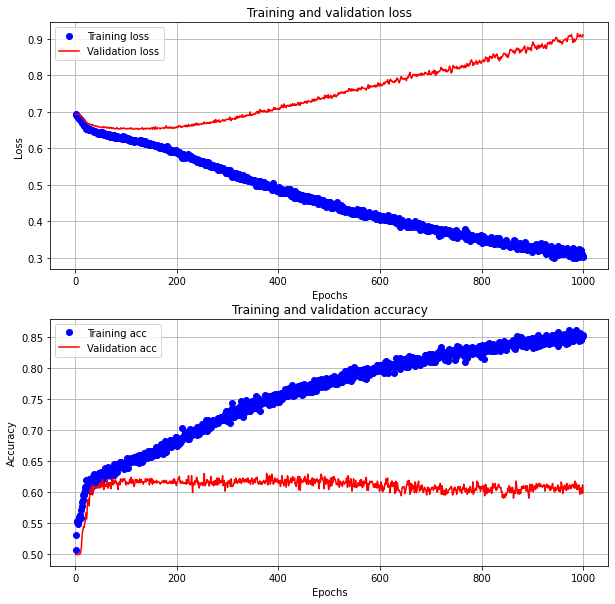

In [0]:

def ploting():
    # print(history.history.keys())
    ac = []
    for i in history.history.keys():
        ac.append(i)
    loss = history.history[ac[2]]
    val_loss = history.history[ac[0]]
    acc = history.history[ac[3]]
    val_acc = history.history[ac[1]]
    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss', color='r')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc', color='r')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    for ax in fig.axes:
        ax.grid(True)
    plt.savefig('graph')
    plt.show()

ploting()

In [0]:
roc_auc_score(y_test, model.predict_proba(X_test)), accuracy_score(y_test.reshape(-1, 1), np.round(model.predict(X_test), 0))

(0.6628978931118319, 0.63)